In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, QTable, join
import glob
import thejoker as tj
import pymc as pm
import corner
from astropy import constants as const

import arviz as az
import astropy.units as u
from astropy.time import Time
from utils import PLOT_PARAMS
PLOT_PARAMS()

In [2]:
apogee_gold  = Table.read("../../lithium/cosmic/apogee_goldsample.fits")
apw_binaries = Table.read('../../lithium/cosmic/apw_binaries.fits')


In [3]:
apogee_dr16_visit = Table.read('../files/apogee_dr16_allVisit-r12-l33.fits')
apogee_dr16_visit.convert_bytestring_to_unicode()


In [4]:
apogee_dr16 = Table.read('../../lithium/data/allStarLite-r12-l33.fits')
apogee_dr16.convert_bytestring_to_unicode()
apogee_dr16 = apogee_dr16[(apogee_dr16['TEFF']>0) & (apogee_dr16['LOGG']>-9000.) ]


In [5]:
galah_mag_lower, galah_mag_upper = 7.456999778747559, 11.829999923706055
mag_lower, mag_upper = 7,12
apogee_rg = apogee_dr16[(apogee_dr16['TEFF']<=5730) & (apogee_dr16['TEFF']>=3000) & 
                        (apogee_dr16['LOGG']<=3.2) & (apogee_dr16['LOGG']>=-1) & 
                        (apogee_dr16['NVISITS']>=4) &
                        (apogee_dr16['WASH_DDO51_GIANT_FLAG']==1) & 
                        (apogee_dr16['J']>=mag_lower) & (apogee_dr16['J']<=mag_upper) 
                        
                       ]
len(apogee_rg)

4363

In [6]:
len(apogee_dr16_visit)

1778792

In [7]:
mask = np.isin(apogee_dr16_visit['APOGEE_ID'], apogee_rg['APOGEE_ID'])

apogee_dr16_visit = apogee_dr16_visit[mask]

In [8]:
apogee_cut  = apogee_rg.copy()
apogee_cut2 = apogee_dr16_visit.copy()

# merged = join(apogee_cut, apogee_cut2, keys='APOGEE_ID')


In [9]:

keep_star = []
for i in apogee_cut:
    starflag   = str(i['STARFLAG'])
    aspcapflag = str(i['ASPCAPFLAG'])
    
    if '3' not in starflag and '16' not in starflag and '16' not in aspcapflag \
    and '17' not in aspcapflag and '18' not in aspcapflag and '26' not in aspcapflag and '30' not in aspcapflag:
        keep_star.append(i['APOGEE_ID'])
        
mask = np.isin(apogee_cut['APOGEE_ID'], keep_star)

apogee_rg_good = apogee_cut[mask]


In [10]:
keep_visit = []
for i in apogee_cut2:
    starflag = str(i['STARFLAG'])
    visit_id = i['VISIT_ID']
    if '3' not in starflag and '9' not in starflag and '12' not in starflag and '13' not in starflag and '16' not in starflag:
        keep_visit.append(visit_id)

mask = np.isin(apogee_cut2['VISIT_ID'], keep_visit)
apogee_visit_good = apogee_cut2[mask]


In [11]:
merged = join(apogee_rg_good, apogee_visit_good, keys='APOGEE_ID', join_type='left')

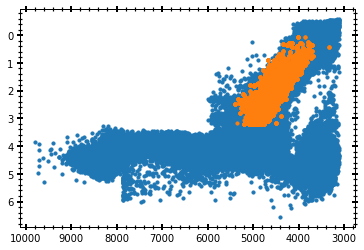

In [12]:
plt.scatter(apogee_dr16['TEFF'],apogee_dr16['LOGG'],s=10)
plt.scatter(merged['TEFF'],merged['LOGG'],s=10)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [13]:
def run_joker(data,Pi,Pf,K0=20, max_posterior=1000, error=0.1,prior_size=1_000_000):#,save=False,MCMC=False):
    time, rv, err = data[0], data[1], data[2]
    err            = np.array(err)
    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    err[(err<0.10)] = 0.10
    
    data           = Table()
    data['bmjd']   = time
    data['rv']     = rv
    data['rv_err'] = err

    #print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    t = Time(data["bmjd"], format="mjd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v=100*u.km/u.s,            
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    
    joker = tj.TheJoker(prior, rng=rnd)


    #print('running joker for posterior samples...')
    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=max_posterior,
                                           return_all_logprobs=True)

#     joker_samples = joker.iterative_rejection_sample(data, prior_samples,n_requested_samples=1000)
# #                                                      return_all_logprobs=True)
    print('# of joker samples returned second round:',len(joker_samples[0]))
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    _ = tj.plot_rv_curves(
            joker_samples[0],
            data=data,
            ax=ax,
        )
    
    return joker_samples
    

In [14]:
# merged[merged['APOGEE_ID']=='2M22141062-0225513'][['JD','VHELIO','VRELERR']]

# apogee_dr16_visit[apogee_dr16_visit['APOGEE_ID']=='2M22141062-0225513'][['JD','VHELIO','VRELERR','STARFLAGS']]

In [15]:

unique_apogee_id = list(set(merged['APOGEE_ID']))
print('# of unique RGs:',len(unique_apogee_id))

done = glob.glob('apogee_reference_samples/*.hdf5')
done = [i.split('/')[-1] for i in done]
done = [i.split('.hdf5')[0] for i in done]
done = list(set(done))

print('done',len(done))
print(len(set(unique_apogee_id)))
print(len(list(set(unique_apogee_id) - set(done))))


# of unique RGs: 3632
done 3504
3632
473


In [16]:
def check_masked_stars():
    
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    masked = []
    not_masked = []
    for i,star in enumerate(unique_apogee_id):
#         print(i, star)

        dtemp   = merged[merged['APOGEE_ID'] == star]
        if len(dtemp) == 1 and dtemp.has_masked_values is True:
            masked.append(star)
        else:
            not_masked.append(star)
    return masked, not_masked

masked, not_masked = check_masked_stars()


# of unique RGs: 3632


In [17]:
len(masked),len(not_masked)


(473, 3159)

In [18]:
plt.rcParams['figure.facecolor'] = 'white'

In [45]:
def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    #unique_apogee_id = list(set(unique_apogee_id) - set(done))
    #print('# of unique RGs:',len(unique_apogee_id))
    
    baseline = []
    for i,star in enumerate(unique_apogee_id):
        #if i<1847: continue
        #680 is when i started to reduce the posterior/prior size
        print(i, star)
        
        dtemp   = merged[merged['APOGEE_ID'] == star]
        if len(dtemp) == 1 and dtemp.has_masked_values is True:
            print('\t','masked content.')
            continue
        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time    = dtemp['JD'].value

        mask = (err<10.)
        
        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time = Time(time, format="jd", scale="tcb")
        time = time.mjd
        baseline.append(max(time)-min(time))
        '''
        #print('\t 2')
        data = [time, rv_vals, err]
        data = np.array(data)
        #np.save('apogee_reference_samples/%s.npy'%star, data )
        #print('\t 3')
        joker_samples = run_joker(data, Pi=1, Pf=3000, prior_size=100_000, max_posterior=256 )
        #print('\t 4')
        save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
        #joker_samples[0].write(save_dir, overwrite=True)
        print('\n')
        '''
    return baseline
baseline = pipeline()


# of unique RGs: 3632
0 2M17170908+4308398
1 2M15175895+0206239
2 2M16352775+0023418
3 2M16144362+5051573
4 2M07542238+6500549
5 2M21251098+1229242
6 2M17171342+4308305
7 2M08085509+3045362
8 2M07561977+6534121
	 masked content.
9 2M16104636+2242007
10 2M07341724+2157526
11 2M11065767-0503243
12 2M15581064-1000305
13 2M15281888+3740468
14 2M22105361-0159423
15 2M11172575+5216087
16 2M00393636+8359378
17 2M12432932-0620457
18 2M13270665-0309158
19 2M07421245+2123286
20 2M11481862+3421022
21 2M01053393+8435014
22 2M16321518-1302031
23 2M22125993-0307223
24 2M17490328+7356062
	 masked content.
25 2M22153600-0326214
26 2M11433284+5534221
27 2M22172684-0220063
28 2M17000022+1123053
29 2M07390723+6456110
30 2M17021642+5948249
31 2M01302640+1636429
	 masked content.
32 2M17153976+4746055
	 masked content.
33 2M21243358+1228505
34 2M16311431-0013055
35 2M11503706+5447593
36 2M14434982+4624424
37 2M11083770-0658005
38 2M16084492+2229504
39 2M15301392+3842347
40 2M01593115-0150337
41 2M16554690+

342 2M09312195+3630056
343 2M17345746+7402209
344 2M13284103-0111093
345 2M17151668+4847264
346 2M15213967+0035587
347 2M01243365+1639063
	 masked content.
348 2M17003568+0943471
349 2M01251747+1734588
350 2M11005214+4826474
351 2M15103833+2546203
352 2M15572070+2808003
353 2M09322836+3641504
354 2M00260878+8404341
355 2M07385063+6450529
356 2M10404161+4428232
357 2M13234097-0116312
358 2M15045876+2049380
359 2M00085821+8452474
360 2M15213568+0054384
361 2M00405390+8527104
362 2M15285826+4213055
363 2M10553041+4741310
364 2M15353609+4205277
365 2M07563324+4049162
366 2M03131099+0200281
367 2M11082238+4855280
368 2M15284718+3756589
369 2M07412243+6532493
370 2M14323816+0739248
371 2M17200194+4951289
372 2M15075185+2804096
373 2M09293794+3636483
374 2M12401384-0705313
375 2M07541594+6519023
376 2M15302669+4238036
377 2M17105086+4905406
378 2M17222746+5954326
379 2M07364554+2240041
380 2M12095241+2101583
381 2M03113497+0034205
382 2M17183676+4905569
383 2M07365596+2220125
384 2M21333569+1

673 2M12455813-0707056
674 2M16075936+2441589
675 2M16571284+1059214
	 masked content.
676 2M12292243+5710033
677 2M15193175+0222472
678 2M16091928+2339336
679 2M12291282+2549486
	 masked content.
680 2M16102076+2401178
681 2M15263601+4347549
682 2M22140211-0255269
683 2M16140644+2414012
684 2M08464224+1153143
685 2M11050020-0532311
686 2M16545194+1155460
687 2M22125643-0237077
	 masked content.
688 2M16085846+2435462
689 2M11003867-0524404
690 2M10543774+4801423
691 2M16270098-1306054
692 2M07322938+2059323
	 masked content.
693 2M13031910+5818173
694 2M13053797-0124078
695 2M16111369+2243526
696 2M15184187+0205537
697 2M15064619+2750080
698 2M21344362+1144137
	 masked content.
699 2M15592124+2913596
700 2M17223231+4858267
701 2M07390000+2032446
702 2M08094773+3205546
703 2M11430424+2651479
704 2M14532014+3725198
705 2M07351111+2037324
706 2M16353680-1308104
	 masked content.
707 2M17115894+4855400
708 2M15043411+2635261
	 masked content.
709 2M10404959+4248040
710 2M16001430+2848440


999 2M01173495+8430127
1000 2M13391796-0032391
	 masked content.
1001 2M13420277+0014544
1002 2M16162475+2201111
1003 2M16542859+1022461
	 masked content.
1004 2M17195996+5836121
1005 2M21255343+1133498
	 masked content.
1006 2M17072589+5934447
1007 2M16301736-0117031
	 masked content.
1008 2M21285546+1130591
1009 2M16055170-1017312
1010 2M01593993-0143386
1011 2M16284475-1408348
1012 2M14592917+2222023
1013 2M13281766-0200324
	 masked content.
1014 2M15173255+0022334
1015 2M08463140+1107466
1016 2M17150336+4814398
	 masked content.
1017 2M15073454+2142198
	 masked content.
1018 2M17225304+4931280
1019 2M12434955-0701393
1020 2M14444123+4700575
1021 2M11051051+4731479
1022 2M17124084+4755054
	 masked content.
1023 2M16371302+0033364
1024 2M14540221+4209549
1025 2M11503654+5407268
1026 2M15034295+2224510
1027 2M15261745+4427165
1028 2M14533165+3741571
1029 2M16371309+0018512
1030 2M07400873+6702472
1031 2M13054181+5714599
1032 2M10445556+2112001
1033 2M13071882-0308067
1034 2M09340713+3

1320 2M15174813+0050050
1321 2M15045707+2231136
1322 2M12214218+5701291
1323 2M15011635+2628491
	 masked content.
1324 2M15580906+2751255
1325 2M16115065+2418232
1326 2M16363670-0117348
1327 2M13202893-0107245
1328 2M15141387+0135392
1329 2M15271410+3822383
1330 2M07371680+2158194
1331 2M13012053+5702552
1332 2M15260878+3838002
1333 2M12275171+5710572
1334 2M16053564-0951208
1335 2M16035911+2714147
1336 2M13394402+0008104
1337 2M13415459+2820595
1338 2M22144953-0110170
1339 2M13410391-0033490
	 masked content.
1340 2M16024875-1006478
1341 2M15163647+0044442
1342 2M15563170+2727148
1343 2M17150463+4839533
1344 2M12433450+1220294
1345 2M01563430-0249467
1346 2M15174702+0204519
1347 2M07351730+6701383
1348 2M15574420+2700562
1349 2M17015894+0959372
1350 2M17192855+4913496
1351 2M12332011+5637015
	 masked content.
1352 2M12161286+0532489
1353 2M13074138-0308561
1354 2M15581315-1156566
	 masked content.
1355 2M17034254+1042380
	 masked content.
1356 2M16060818-1020238
1357 2M17241637+475516

1647 2M11445674-1519321
	 masked content.
1648 2M13361453+2841554
1649 2M16010793+2831308
1650 2M12090641+1935137
1651 2M11050160-0549412
1652 2M07372731+2134182
1653 2M13413024+2822163
1654 2M13074947-0202080
1655 2M11430893+5531286
1656 2M15273125+3823573
1657 2M14501586+4552581
1658 2M15160639+0006232
1659 2M14350419+5100215
1660 2M15200965+8457276
1661 2M15585501+2707457
1662 2M11024636+4805250
1663 2M14233259+5032332
1664 2M08093034+3221455
1665 2M16064395+2346490
1666 2M13015576+5750317
1667 2M13423523+2716167
1668 2M13020472+5743438
1669 2M16135374+2232297
1670 2M13240162-0047151
1671 2M11055830-0517478
1672 2M03175286+0009106
1673 2M07373694+2057036
	 masked content.
1674 2M16264659-1219367
1675 2M16564817+0945170
1676 2M07490465+6700340
1677 2M17085767+5819357
1678 2M00581221+8435283
1679 2M07400277+6600361
1680 2M14441449+1346159
1681 2M03221197+0104290
1682 2M21303963+1205235
1683 2M07321863+2153533
1684 2M01565910-0300587
1685 2M21283786+1214341
1686 2M16304899-1224038
1687

1965 2M08125527+3247577
1966 2M17140270+4339473
1967 2M16093984+2442064
1968 2M16125040+2424525
1969 2M16043671+2904475
1970 2M17554453+7258002
1971 2M13015219-0244107
	 masked content.
1972 2M15245099+8448485
1973 2M08100978+3037053
1974 2M14401536+1355337
1975 2M11082276+4838113
1976 2M17414053+7423042
1977 2M16305429-1154319
1978 2M03174474+0138191
1979 2M13200936-0208524
	 masked content.
1980 2M17171307+4309483
1981 2M15580311+2810290
1982 2M21340738+1210394
	 masked content.
1983 2M15233852+3836008
1984 2M16063785-1108551
1985 2M16062136+2337147
1986 2M01265017+1742214
1987 2M07375667+2042460
1988 2M14402270+1232275
	 masked content.
1989 2M11165171+5201132
1990 2M14483158+1203144
1991 2M17023125+1115545
1992 2M00230310+8409529
1993 2M12003904+5443144
1994 2M13442105+2808345
1995 2M17094485+6007100
1996 2M12414000-0825021
1997 2M16395923+3648194
1998 2M15585209-1011329
1999 2M16554510+1021485
	 masked content.
2000 2M07554721+4121400
2001 2M16454196+3723161
2002 2M13390263-000939

2286 2M11042074-0643075
2287 2M21253666+1252451
2288 2M15184540+0204302
2289 2M16064785+2909381
2290 2M16262907-1219357
2291 2M16285561-1409432
2292 2M17084936+5806025
2293 2M21340499+1150237
2294 2M10391178+1902040
	 masked content.
2295 2M13030303-0146350
2296 2M16340687-0104536
	 masked content.
2297 2M16335077-1353243
2298 2M13410322+2826217
2299 2M10285800+1545425
2300 2M22103209-0126464
2301 2M16012724+2931395
2302 2M15204175+0038031
2303 2M07384367+2139557
2304 2M16353099+0002315
2305 2M11093808-0516346
2306 2M13083747-0225372
2307 2M17185474+5932549
2308 2M11083590-0546573
2309 2M07411627+2225162
2310 2M14463198+4700218
2311 2M15153777-0020060
2312 2M16563200+1024306
	 masked content.
2313 2M17240477+4739119
2314 2M11450147+5546248
2315 2M16354966-0139213
2316 2M16030365-1205445
2317 2M16275204-1346069
2318 2M03151508+0217374
2319 2M13292839-0219449
	 masked content.
2320 2M14322422+0938437
2321 2M17015650+1137589
2322 2M10102874+0323261
2323 2M07430931+2144286
2324 2M01250889+

2622 2M14402654+1307125
2623 2M12044439+2003287
2624 2M01570353-0155092
2625 2M12472014+1240467
2626 2M12403819-0706042
2627 2M16311234-0039107
	 masked content.
2628 2M03182045+0204263
2629 2M15083573+2736473
2630 2M17140034+6041252
2631 2M07364113+2229379
2632 2M00463920+8523336
2633 2M22101385-0141436
2634 2M21333377+1102304
2635 2M14514097+4703338
2636 2M14313933+4919376
	 masked content.
2637 2M11064854+4742402
2638 2M16285197-1315231
	 masked content.
2639 2M12283758+5541491
2640 2M16430093+3730193
2641 2M07334656+6611317
2642 2M17221259+4752487
2643 2M17150336+6046590
2644 2M13270051-0100012
2645 2M17014558+1146009
2646 2M12114140+0438075
2647 2M11105688-0514331
2648 2M22161074-0212514
	 masked content.
2649 2M14392579+1206198
	 masked content.
2650 2M15313501+4247431
2651 2M12244558+2644445
2652 2M15064345+4211234
2653 2M08120331+2808283
2654 2M07405195+2148487
2655 2M14232430+5018169
	 masked content.
2656 2M21291569+1132328
2657 2M17183226+4931114
2658 2M14312103+0821346
2659

2926 2M12485375+1122328
2927 2M14555816+2225381
2928 2M15583198-1036594
2929 2M12113007+0426224
2930 2M22181781-0134413
2931 2M13220731-0032181
2932 2M17412486+7338391
	 masked content.
2933 2M12450583-0743394
2934 2M14364694+0909280
2935 2M14591551+4053499
	 masked content.
2936 2M14475591+1148507
2937 2M07453016+6439058
2938 2M21295678+1210269
2939 2M16325188-1155107
2940 2M22145393-0234296
	 masked content.
2941 2M03135396+0026467
2942 2M16065217+2422367
2943 2M08513938+1151456
2944 2M13252636-0313429
2945 2M17123270+5800530
2946 2M13332417+2750115
2947 2M16002768-1157060
2948 2M17232209+4841192
2949 2M11464031+5520291
2950 2M13424426-0113370
2951 2M17470016+7245410
2952 2M21345062+1228468
2953 2M16035540+2918415
2954 2M08153324+2904204
2955 2M16281311-1336334
	 masked content.
2956 2M13264212-0229425
2957 2M17570984+7517312
2958 2M13043438-0203230
2959 2M07325609+2107546
	 masked content.
2960 2M03165423+0059233
2961 2M15114816+8500009
2962 2M03113523+0133391
2963 2M11014256+490227

3244 2M17191624+6019269
3245 2M08132921+3236472
3246 2M16012127-1219276
3247 2M16063752-1054003
3248 2M01415794+8520066
3249 2M07334184+2142309
3250 2M17173534+4818354
	 masked content.
3251 2M13084615-0211346
3252 2M15113586+0026255
3253 2M08120696+2904392
3254 2M13433258+2706547
3255 2M12122154+1917042
3256 2M14342704+0734564
3257 2M16144612+2337504
3258 2M16045884+2848524
3259 2M16004341+2652137
3260 2M16161768+2210306
3261 2M17182513+4932005
3262 2M15230532+4238487
3263 2M13383256+2752379
3264 2M22172350-0236539
3265 2M15234497+4439317
3266 2M10421611+2047297
3267 2M16591650+0953017
3268 2M10414930+2108092
3269 2M11163186+5133199
3270 2M16101801+2500108
3271 2M17115494+4742064
	 masked content.
3272 2M13485340+0132175
3273 2M13470876+2727048
3274 2M16572176+1024437
	 masked content.
3275 2M17135451+4842382
3276 2M08100085+3050211
3277 2M01250689+1754382
3278 2M17115484+4736154
	 masked content.
3279 2M16330005-0023450
3280 2M16003938+2920404
3281 2M01251775+1653180
	 masked content

3565 2M15300168+4401108
3566 2M11011902-0530309
3567 2M13420686-0052064
3568 2M16103953+2409507
3569 2M13463316+0010086
3570 2M16584672+1111276
3571 2M17223355+4903496
3572 2M15044099+3700503
3573 2M12123903+0548400
3574 2M16333748-1226537
3575 2M14570345+4125531
	 masked content.
3576 2M08085353+3152009
3577 2M17062311+5931062
3578 2M22111657-0118321
3579 2M13404672+2724592
3580 2M10402517+1927328
	 masked content.
3581 2M15072738+2123130
	 masked content.
3582 2M00422570+8516219
3583 2M10531036-0139010
3584 2M15581329+2840528
3585 2M13423397+2745255
3586 2M12491710-0800417
	 masked content.
3587 2M01042557+8401077
3588 2M17421336+7425162
3589 2M16331411-1223102
3590 2M15131768+8508493
3591 2M17495022+7429040
3592 2M07461396+6549226
	 masked content.
3593 2M16362654-0117592
3594 2M16341606-1340534
	 masked content.
3595 2M12120416+0608357
3596 2M15293794+4324114
3597 2M14452925+1359449
3598 2M03190120-0010156
3599 2M13454556+2909250
3600 2M15132332+0148026
3601 2M15143669+0156208
3602

In [47]:
min(baseline),max(baseline)

(0.9178500003181398, 2479.8477199999616)

In [20]:
def check_amp():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))

    files = glob.glob('apogee_reference_samples/*.hdf5')
    names = [file.split('/')[-1].split('.')[0] for file in files]
    
    print('done:',len(set(names)))
    print('remaining:',len(list(set(unique_apogee_id)-set(names))))

    c_uni_modal = []
    c_multi     = []
    n_samples   = []
    
    for file in files:
        name = file.split('/')[-1].split('.')[0]
        if name in unique_apogee_id:
            samples = tj.JokerSamples.read(file)
            if len(samples) == 1:
                #reload(name, n=1)
                c_uni_modal.append(name)
            else:
                c_multi.append(name)
    return [c_uni_modal, c_multi]

n_samples = check_amp()

# of unique RGs: 3632
done: 3504
remaining: 473


In [21]:
def func2(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def check_K(name):
    samples = tj.JokerSamples.read('apogee_reference_samples/%s.hdf5'%name)
    K_vals  = abs(samples['K'].value)
    perc_5  = np.percentile(K_vals, 5) #km/s
    logg    = merged[merged['APOGEE_ID']==name]['LOGG'].value[0]
    exp_35  = func2(logg)/1000.
    obs_K   = perc_5*1
    #print('exp: %.2f \t obs: %.2f'%(exp_35, obs_K))
    return obs_K,exp_35

yes_names = []
for i,name in enumerate(n_samples[1]):
    obs_K, exp_35 = check_K(name)
    if obs_K >= exp_35:
        yes_names.append(name)


In [22]:
Queiroz_2019 = Table.read('../files/Queiroz_2019.fit')

In [23]:
uni_modal_samples = n_samples[0]
mul_modal_samples = n_samples[1]

In [24]:
len(mul_modal_samples), len(uni_modal_samples),len(unique_apogee_id), len(yes_names)

(3097, 62, 3632, 528)

In [25]:
(len(yes_names) + len(uni_modal_samples))/(len(unique_apogee_id)-473)

0.18676796454574232

In [26]:
def load_samples_info(name, mul=False):
    samples = tj.JokerSamples.read('apogee_reference_samples/%s.hdf5'%name)
    dtemp   = Queiroz_2019[Queiroz_2019['ID'] == name]
    Mstar   = dtemp['Mass50'].value
    em1 = dtemp['Mass50'] - dtemp['Mass16']
    em2 = dtemp['Mass84'] - dtemp['Mass50']
    em  = 0.5*(em1+em2) #average mass in error
    
    
    if len(Mstar) == 0 :
        print(name)
        Mstar = np.nan
        em = np.nan
    else:
        Mstar = Mstar[0]
    
    if mul:
        K, P, e = samples['K'].value, samples['P'].value, samples['e'].value
    else:
        K, P, e = samples['K'].value[0], samples['P'].value[0], samples['e'].value[0]
    
    return K, P, e, Mstar, em
#load_samples_info(uni_modal_samples[0])


#load_samples_info(mul_modal_samples[0],mul=True)

In [29]:
uni_modal_dict = {'APOGEE_ID': [], 'K': [], 'P': [], 'e': [], 'Mstar': [], 'eMstar': [], 'Msini_jup': []}

for name in uni_modal_samples:
    K, P, e, Mstar, eMstar = load_samples_info(name)
    Msini, _ = msini_func(K, P, e, Mstar)
    Msini_jup   = Msini/u.M_jup.to(u.kg)
            
    uni_modal_dict['APOGEE_ID'].append(name)
    uni_modal_dict['K'].append(abs(K))
    uni_modal_dict['P'].append(P)
    uni_modal_dict['e'].append(e)
    uni_modal_dict['Mstar'].append(Mstar)
    uni_modal_dict['eMstar'].append(eMstar)
    uni_modal_dict['Msini_jup'].append(Msini_jup[0])
    

2M13415973+2822567
2M21300274+1210438
2M16132502+2241142
2M11414364+2623592


In [30]:
uni_modal_df = pd.DataFrame(uni_modal_dict)

In [31]:
mul_modal_dict = {'APOGEE_ID': [], 'K': [], 'P': [], 'e': [], 
                  'K50': [], 'P50': [], 'e50': [], 
                  'Mstar': [], 'eMstar': [], 'Msini_jup': [], 'Mj50': []}

for ii,name in enumerate(mul_modal_samples):
    if name not in yes_names: continue
    Ks, Ps, es, Mstar, eMstar = load_samples_info(name,mul=True)
    Mjup = np.empty(len(Ks))
    Mstar_samples = np.random.normal(Mstar, eMstar, size=len(Ks))

    for i in range(len(Ks)):
        K, P, e = Ks[i], Ps[i], es[i]
        Msini, _ = msini_func(K, P, e, Mstar_samples[i])
        Msini_jup   = Msini/u.M_jup.to(u.kg)
        Mjup[i] = Msini_jup
            
    mul_modal_dict['APOGEE_ID'].append(name)
    mul_modal_dict['K'].append(abs(Ks))
    mul_modal_dict['P'].append(Ps)
    mul_modal_dict['e'].append(es)
    mul_modal_dict['Mstar'].append(Mstar_samples)
    mul_modal_dict['eMstar'].append(eMstar)
    mul_modal_dict['Msini_jup'].append(Mjup)
    mul_modal_dict['Mj50'].append(np.percentile(Mjup, 50))
    mul_modal_dict['P50'].append(np.percentile(Ps, 50))
    mul_modal_dict['K50'].append(np.percentile(Ks, 50))
    mul_modal_dict['e50'].append(np.percentile(es, 50))
    print(ii)

<ipython-input-31-f60ab6eb4ce2>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mjup[i] = Msini_jup
<ipython-input-28-c745d77fc257>:31: RuntimeWarning: invalid value encountered in power
  return x - (Mstar + x)**(2./3.) * a # x = Msini


4
8
12
14
21
26
30
53
57
60
61
63
78
92
95
102
110
111
119
122
133
136
138
156
158
163
168
171
179
181
191
196
211
218
222
230
231
233
236
239
244
247
250
252
267
270
272
273
276
287
299
300
302
303
310
312
316
317
321
328
335
341
350
353
358
366
373
389
390
392
393
404
405
418
420
424
428
2M16414879+3626505
434
435
437
440
445
447
450
454
455
462
468
473
474
497
501
510
517
519
523
528
530
558
562
563
564
582
588
591
609
611
613
615
625
629
633
635
636
640
641
643
649
654
668
680
691
692
696
702
703
711
716
726
728
735
737
740
746
748
751
755
757
761
767
768
769
774
775
780
784
785
2M11055830-0517478
786
791
797
808
812
822
830
831
841
842
848
851
852
860
869
874
882
889
891
892
893
904
916
937
949
952
964
989
999
1007
1010
1022
1023
1033
1035
1039
1042
1050
1053
1055
1059
1061
1065
1069
1080
1087
1100
1102
1105
1122
1124
1125
1136
1138
1145
1151
1164
1166
1175
1176
1183
1185
1186
1188
1193
1199
1204
1206
1212
1213
1230
1231
1235
1240
1241
1243
1249
1266
1267
1275
1281
1283
1286
1293


In [32]:
mul_modal_df = pd.DataFrame(mul_modal_dict)

In [33]:
c=0

visit_max_5 = []

for target in set(mul_modal_df['APOGEE_ID']):
    nvisit = apogee_rg[apogee_rg['APOGEE_ID']==target]['NVISITS'].value
    if len(nvisit) > 1:
        if min(nvisit) <=5:
            visit_max_5.append(target) 
    else:
        if nvisit[0] <=5:
            visit_max_5.append(target) 

for target in set(uni_modal_df['APOGEE_ID']):
    nvisit = apogee_rg[apogee_rg['APOGEE_ID']==target]['NVISITS'].value
    if len(nvisit) > 1:
        if min(nvisit) <=5:
            visit_max_5.append(target) 
    else:
        if nvisit[0] <=5:
            visit_max_5.append(target) 


In [34]:
mul_good = mul_modal_df[mul_modal_df['APOGEE_ID'].isin(visit_max_5)]
uni_good = uni_modal_df[uni_modal_df['APOGEE_ID'].isin(visit_max_5)]


In [35]:
len(mul_good),len(uni_good),len(mul_modal_df),len(uni_modal_df)

(435, 24, 528, 62)

total within P<100 days & Mj<1000: 71
colored points left of red line: 18


0.2535211267605634

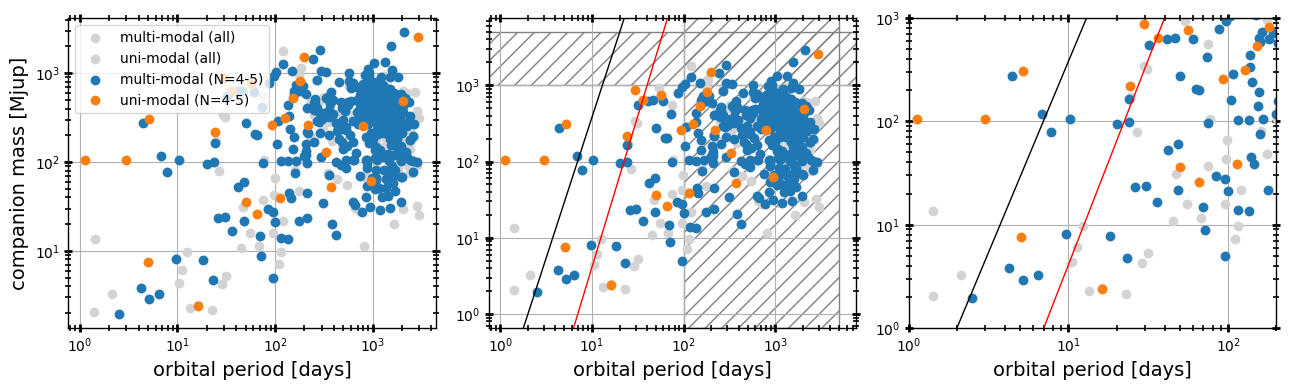

In [36]:


fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4),dpi=100)


for ax in [ax1, ax2, ax3]:
    ax.scatter(mul_modal_df['P50'], mul_modal_df['Mj50'], label='multi-modal (all)', c='lightgrey')
    ax.scatter(uni_modal_df['P'], uni_modal_df['Msini_jup'], label='uni-modal (all)', c='lightgrey')

    ax.scatter(mul_good['P50'], mul_good['Mj50'], label='multi-modal (N=4-5)')
    ax.scatter(uni_good['P'], uni_good['Msini_jup'], label='uni-modal (N=4-5)')

    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('orbital period [days]')
    
    ax.grid()

ax2.axline((7, 1), (40, 1000), linewidth=1, color='r')
ax2.axline((2, 1), (13, 1000), linewidth=1, color='k')

ax3.axline((7, 1), (40, 1000), linewidth=1, color='r')
ax3.axline((2, 1), (13, 1000), linewidth=1, color='k')

ax1.legend(loc='upper left',fontsize=10)   
ax1.set_ylabel('companion mass [Mjup]')
    
ax2.axvspan(100,5000,edgecolor='grey',hatch='//',facecolor='None',zorder=-100)
ax2.axhspan(1000,5000,edgecolor='grey',hatch='//',facecolor='None',zorder=-100)


ax3.set_xlim(1,200)
ax3.set_ylim(1,1000)

plt.tight_layout()


mask1 = (np.array(mul_good['P50'])<180) & (np.array(mul_good['Mj50'])<1000)
mask2 = (np.array(uni_good['P'])<180) & (np.array(uni_good['Msini_jup'])<1000)

cut_1 = np.array(mul_good['APOGEE_ID'])[mask1]
cut_2 = np.array(uni_good['APOGEE_ID'])[mask2]
print('total within P<100 days & Mj<1000:',len(cut_1)+len(cut_2))
print('colored points left of red line:',18)
18/71

In [37]:
M_jup = 1.898e27               # Jupiter mass (kg)
day = 86400                    # seconds in a day


prob_e0  = np.load('simulation_data/probability_e=0.npy')
M_grid   = np.load('simulation_data/M_grid.npy') #kg
M_grid  /= M_jup #in Mjup
P_grid   = np.load('simulation_data/P_grid.npy') #seconds
# P_grid  /= day #in days

In [38]:
np.shape(prob_e0),np.shape(P_grid),np.shape(M_grid)

((500, 500), (500,), (500,))

In [39]:
# P_grid
# M_grid

In [40]:

def get_nearest_z(x1, y1, x_vals, y_vals, z_grid):
    # Find nearest indices in x and y
    ix = (np.abs(x_vals - x1)).argmin()
    iy = (np.abs(y_vals - y1)).argmin()
    
    # Return z at the nearest grid point
    return z_grid[iy, ix], x_vals[ix], y_vals[iy]

# Example usage:
P1, M1 = 523.4, 37.8
P1, M1 = 3, 7
x1, y1 = P1, M1

P_range = np.logspace(0, np.log10(365*10.), 100)
M_range = np.logspace(0, 3, 50)*M_jup         # companion mass (M*sin i)

x_vals = P_range*1
y_vals = M_range*1
z_grid = prob_e0*1

np.shape(x_vals),np.shape(y_vals),np.shape(z_grid)
z_value, nearest_x, nearest_y = get_nearest_z(x1, y1, x_vals, y_vals, z_grid)
print(z_value, nearest_x, nearest_y)

0.7236363636363639 2.9361337197847885 1.898e+27


0.7236363636363639


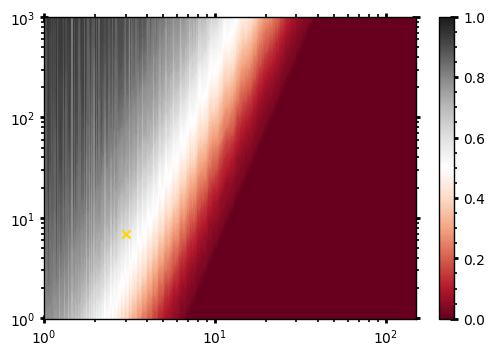

In [41]:
cmap_color = 'RdGy'
bounds = [0., 0.2, 0.4, 0.6, 0.8, 1.0]
cmap = plt.get_cmap(cmap_color, len(bounds))

plt.figure(dpi=100)
ax=plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')

mesh=ax.pcolormesh(P_grid, M_grid, prob_e0,vmax=1,cmap=cmap_color)#, cmap=cmap, norm=norm)

plt.colorbar(mesh)
ax.scatter(P1, M1,c='gold',marker='x')
ax.grid(True,color='white')
ax.set_xlim(1,150)
print(z_value)
plt.show()

In [42]:
mul_modal_df['P50'], mul_modal_df['Mj50']

prob_mul = []

for index, row in mul_good.iterrows():
    P1, M1 = row['P50'],row['Mj50']
    p, _, _ = get_nearest_z(P1, M1, x_vals, y_vals, z_grid)
    prob_mul.append(p)

prob_uni = []

for index, row in uni_good.iterrows():
    P1, M1 = row['P'],row['Msini_jup']
    p, _, _ = get_nearest_z(P1, M1, x_vals, y_vals, z_grid)
    prob_uni.append(p)

print(np.sum(prob_mul),len(mul_good))
print(np.sum(prob_uni),len(uni_good))
print(np.sum(prob_mul)+np.sum(prob_uni),len(mul_good)+len(uni_good))


116.70957575757576 435
11.246060606060608 24
127.95563636363637 459


In [ ]:
ss

In [ ]:
import random
# random.random(0,1,10)
random.seed(42)
aa = np.array([round(random.uniform(0, 1),2) for i in range(3631)])
np.sum(aa),np.sum(aa)/3631
# aa

In [ ]:
uni_P = np.array(uni_modal_dict['P'])
mul_P = np.array(mul_modal_dict['P50'])

len(uni_P[uni_P<10]),len(uni_P), len(mul_P)

In [28]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    @return:
        Msini: Msini in kg
    '''
    from scipy import optimize
    # define constants
    pi = np.pi
    G  = const.G
    
    # convert units to SI units
    K = abs((K*(u.km/u.second)).to(u.meter/u.second))
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # if Mp << Mstar:
    # Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a     = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    initial_guess = 0.1*u.Msun.to(u.kg)
    
    sol   = optimize.root(func, initial_guess, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success




In [ ]:
print(len(n_samples[0]), len(n_samples[1]),len(yes_names),'total stars run:',len(n_samples[0])+len(n_samples[1]))

(len(n_samples[0]) + len(yes_names)) / (len(n_samples[0]) + len(n_samples[1])+ len(yes_names))


In [ ]:
def reload(name,n=100):

    samples = tj.JokerSamples.read('apogee_reference_samples/%s.hdf5'%name)
    data    = np.load('apogee_reference_samples/%s.npy'%name)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    t = Time(data[0], format="mjd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data[1]*u.km/u.s, rv_err=data[2]*u.km/u.s)
    
    _ = tj.plot_rv_curves(
            samples[:n],
            data=data,
            ax=ax,
        )
    plt.savefig('apogee_reference_samples/%s.png'%name,bbox_inches='tight',dpi=100)

#reload('2M07370225+2201156')

In [ ]:
len(np.array(n_samples)[np.array(n_samples)>1]),len(n_samples)
3093/3155

In [ ]:
ss

In [ ]:
def checking():
    
    files = glob.glob('apogee_reference_samples/*.hdf5')
    
    x = []
    
    for file in files:
        name = file.split('/')[-1].split('.')[0]
        if name in unique_apogee_id:
            samples = tj.JokerSamples.read(file)
            x.append(len(samples))
    x=np.array(x)
    print(len(x))
    print(len(x[x>256]))
#     plt.hist(x,bins='auto')
checking()

In [ ]:
tj.JokerSamples.read('apogee_reference_samples/2M07370225+2201156.hdf5')#['P']

In [ ]:
ss

In [ ]:
def pipeline():
    unique_apogee_id = list(set(merged['APOGEE_ID']))
    print('# of unique RGs:',len(unique_apogee_id))
    
    new_df = {'APOGEE_ID':[],
              'semi_amp': [],
              'logg': [],
              'deltat': []
             }
    
    
    for i,star in enumerate(unique_apogee_id):
        print(i, star)

        dtemp = merged[merged['APOGEE_ID'] == star]
        rv_vals = dtemp['VHELIO'].value
        err     = dtemp['VRELERR'].value
        time = dtemp['JD']
        time = Time(time, format="jd", scale="tcb")
        mask = (err<10.)
        
        time, rv_vals, err = time[mask], rv_vals[mask], err[mask]
        time   = time.mjd
        if len(rv_vals) < 1: continue
        
        semi_k = (max(rv_vals) - min(rv_vals))*0.5
        log_g  = dtemp['LOGG'][0]
#         print(log_g, semi_k)
        new_df['APOGEE_ID'].append(star)
        new_df['semi_amp'].append(semi_k)
        new_df['logg'].append(log_g)
        new_df['deltat'].append(max(time)-min(time))
    return new_df  
        
#         data = [time, rv_vals, err]
#         data = np.array(data)
#         np.max()
#         np.save('apogee_reference_samples/%s.npy'%star, data )
        
#         joker_samples = run_joker(data, Pi=1, Pf=3000)
#         save_dir = 'apogee_reference_samples/%s.hdf5'%(star)
#         joker_samples[0].write(save_dir, overwrite=True)
        #print('\n')
      
new_df = pipeline()
        

In [ ]:
def func1(logg):
    a, b = -0.60, 3.31
    log_v = a*logg+b
    return 10.**log_v
    

def func3(logg):
    siga, sigb = -0.04, -0.10
    a, b = -0.60, 3.31
    a = a+3.5*siga
    b = b+3.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
def func4(logg):
    siga, sigb = 0.04, 0.10
    a, b = -0.60, 3.31
    a = a+1.5*siga
    b = b+1.5*sigb
    log_v = (a*logg+b)
    return 10.**log_v
    
    

In [ ]:
merged.keys()

In [ ]:
new_df_2 = pd.DataFrame(new_df)
new_df_2['exp_amp'] = func2(new_df_2['logg'])/1000.# func2()/1000.

mask = (new_df_2['semi_amp'] >= new_df_2['exp_amp'])

# PLOTTING
plt.figure(dpi=100)
xvals = np.linspace(0.5,3.5,1000)
plt.scatter(new_df_2['logg'], new_df_2['semi_amp'],label='red giants with N>4 visits')
plt.scatter(new_df_2[mask]['logg'], new_df_2[mask]['semi_amp'],label='binary candidates')
plt.plot(xvals, func1(xvals)/1000., c='k')
plt.plot(xvals, func2(xvals)/1000., c='r',ls='dashed')
plt.plot(xvals, func3(xvals)/1000., c='grey',ls='dashed')
plt.xlabel('Logg [dex]')
plt.ylabel('Semi-amplitude [km/s]')
plt.yscale('log')
plt.legend()


print(len(new_df_2[mask]),len(new_df_2),len(new_df_2[mask])/len(new_df_2))



In [ ]:
bins='auto'#np.linspace(0,2500, 25)
plt.figure(dpi=100)
_ = plt.hist(new_df_2['deltat'],bins=bins,alpha=0.5,label='red giants with N>4 visits')
_ = plt.hist(new_df_2[mask]['deltat'],bins=bins,alpha=0.5,label='binary candidates')
plt.xlabel('observation baseline [days]')
plt.ylabel('counts')
plt.legend()


In [ ]:
ss

In [ ]:
# 2M16073621+2252268.hdf5

# def load(name):
#         samples = JokerSamples.from_hdf5(results_f[star['APOGEE_ID']], 
#                                      poly_trend=poly_trend)
        

In [ ]:
# merge = join(apogee_dr16_visit, apogee_rg, keys='APOGEE_ID')
# VHELIO
# PERSIST_LOW
# apogee_dr16_visit[apogee_dr16_visit['APOGEE_ID']==apogee_rg['APOGEE_ID'][0]]

In [ ]:
print(max(apogee_dr16['NVISITS']))
plt.figure()
plt.hist(apogee_dr16['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.hist(apogee_rg['NVISITS'],bins=[0,1,2,3,4,5,6,7,8,9,10,20,30,50])
plt.show()

plt.figure()
plt.scatter(apogee_dr16['TEFF'],apogee_dr16['LOGG'])
plt.scatter(apogee_rg['TEFF'],apogee_rg['LOGG'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('teff')
plt.ylabel('logg')
plt.show()

In [ ]:
apogee_dr16['TARGFLAGS']
apogee_dr16[apogee_dr16['APOGEE_TARGET1']>=0]#apogee_dr16[['APOGEE_TARGET1','APOGEE_TARGET2']]

In [ ]:
# apogee_dr16#.keys()
len(apogee_rg)

In [ ]:
set(apogee_rg['WASH_DDO51_GIANT_FLAG'])#.keys()
